In [1]:
from pandas_datareader import data as datareader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime

In [18]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import r2_score, matthews_corrcoef, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
np.random.seed(0)

# Data reading

In [6]:
# !pip install yahoofinancials

In [7]:
from yahoofinancials import YahooFinancials

In [8]:
TICKER = 'DB'

In [9]:
aapl_yf = yahoo_financials_tech = YahooFinancials([TICKER])
data = aapl_yf.get_historical_price_data('2000-01-01', '2020-08-01', 'daily')

In [ ]:
data[TICKER]['prices']

In [11]:
data = pd.DataFrame(data[TICKER]['prices'])
data = data.set_index('formatted_date')

In [12]:
data = data.dropna()

In [13]:
data

,date,high,low,open,close,volume,adjclose
formatted_date,,,,,,,
2000-01-03,946909800,82.061066,76.574425,77.767174,77.767174,32174,55.155624
2000-01-04,946996200,78.005722,76.335876,76.693703,76.693703,24942,54.394279
2000-01-05,947082600,80.391220,78.244278,78.602097,78.602097,21694,55.747780
2000-01-06,947169000,82.061066,80.391220,80.391220,80.391220,20122,57.016708
2000-01-07,947255400,83.969467,83.015266,83.969467,83.969467,27353,59.554539
...,...,...,...,...,...,...,...
2020-07-27,1595856600,9.570000,9.480000,9.530000,9.550000,1890800,9.062883
2020-07-28,1595943000,9.470000,9.320000,9.400000,9.450000,3287700,8.967984
2020-07-29,1596029400,9.250000,8.940000,8.980000,9.220000,11404400,8.749717


# Data Preparation

In [47]:
!git clone https://github.com/hudson-and-thames/mlfinlab.git

Cloning into 'mlfinlab'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 211 (delta 31), reused 71 (delta 21), pack-reused 87
Receiving objects: 100% (211/211), 665.48 KiB | 6.10 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [105]:
!rm -rf /content/mlfinlab

In [48]:
from mlfinlab.features.fracdiff import frac_diff_ffd
from utils import get_meta_barier, getDailyVol

In [49]:
data['close'].shape

(5178,)

In [50]:
try:
    frac_diff_series = frac_diff_ffd(pd.DataFrame(np.log(data['close'])), 0.7, thresh=1e-4)
except:
    print('Not calculated')
    frac_diff_series = pd.DataFrame(np.log(data['close'])).pct_change()

<Axes: xlabel='formatted_date'>

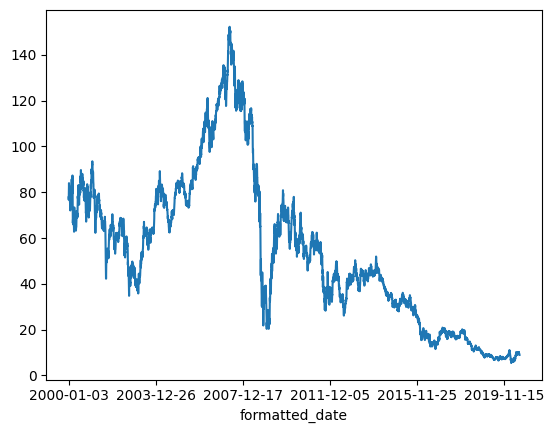

In [51]:
data['close'].plot()

<Axes: xlabel='formatted_date'>

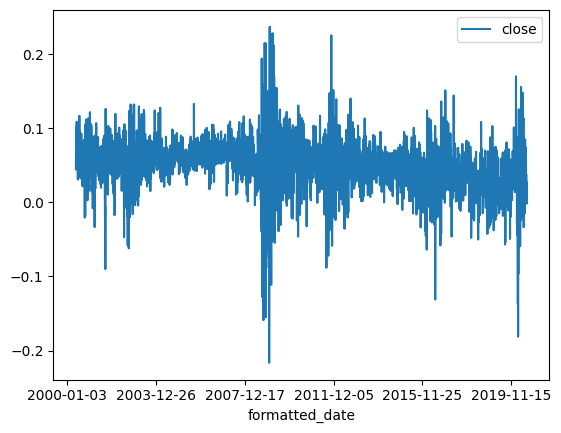

In [52]:
frac_diff_series.plot()

# Feature Extraction

In [106]:
"""
Second generation models features: Kyle lambda, Amihud Lambda, Hasbrouck lambda (bar and trade based)
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


# pylint: disable=invalid-name
def get_bar_based_kyle_lambda(close: pd.Series, volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Kyle lambda from bars data, p.286-288.

    :param close: (pd.Series) Close prices
    :param volume: (pd.Series) Bar volume
    :param window: (int) rolling window used for estimation
    :return: (pd.Series) of Kyle lambdas
    """
    close_diff = close.diff()
    close_diff_sign = np.sign(close_diff)
    close_diff_sign.replace(0, method='pad', inplace=True)  # Replace 0 values with previous
    volume_mult_trade_signs = volume * close_diff_sign  # bt * Vt
    return (close_diff / volume_mult_trade_signs).rolling(window=window).mean()


def get_bar_based_amihud_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Amihud lambda from bars data, p.288-289.

    :param close: (pd.Series) Close prices
    :param dollar_volume: (pd.Series) Dollar volumes
    :param window: (int) rolling window used for estimation
    :return: (pd.Series) of Amihud lambda
    """
    returns_abs = np.log(close / close.shift(1)).abs()
    return (returns_abs / dollar_volume).rolling(window=window).mean()


def get_bar_based_hasbrouck_lambda(close: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Hasbrouck lambda from bars data, p.289-290.

    :param close: (pd.Series) Close prices
    :param dollar_volume: (pd.Series) Dollar volumes
    :param window: (int) rolling window used for estimation
    :return: (pd.Series) of Hasbrouck lambda
    """
    log_ret = np.log(close / close.shift(1))
    log_ret_sign = np.sign(log_ret).replace(0, method='pad')

    signed_dollar_volume_sqrt = log_ret_sign * np.sqrt(dollar_volume)
    return (log_ret / signed_dollar_volume_sqrt).rolling(window=window).mean()


def get_trades_based_kyle_lambda(price_diff: list, volume: list, aggressor_flags: list) -> float:
    """
    Get Kyle lambda from trades data, p.286-288.

    :param price_diff: (list) of price diffs
    :param volume: (list) of trades sizes
    :param aggressor_flags: (list) of trade directions [-1, 1]  (tick rule or aggressor side can be used to define)
    :return: (float) Kyle lambda for a bar
    """
    model = LinearRegression(fit_intercept=False, copy_X=False)
    signed_volume = np.array(volume) * np.array(aggressor_flags)
    X = np.array(signed_volume).reshape(-1, 1)
    y = np.array(price_diff)
    model.fit(X, y)
    return model.coef_[0]


def get_trades_based_amihud_lambda(log_ret: list, dollar_volume: list) -> float:
    """
    Get Amihud lambda from trades data, p.288-289.

    :param log_ret: (list) of log returns
    :param dollar_volume: (list) of dollar volumes (price * size)
    :return: (float) Amihud lambda for a bar
    """
    model = LinearRegression(fit_intercept=False, copy_X=False)
    X = np.array(dollar_volume).reshape(-1, 1)
    y = np.abs(np.array(log_ret))
    model.fit(X, y)
    return model.coef_[0]


def get_trades_based_hasbrouck_lambda(log_ret: list, dollar_volume: list, aggressor_flags: list) -> float:
    """
    Get Amihud lambda from trades data, p.289-290.

    :param log_ret: (list) of log returns
    :param dollar_volume: (list) of dollar volumes (price * size)
    :param aggressor_flags: (list) of trade directions [-1, 1]  (tick rule or aggressor side can be used to define)
    :return: (float) Amihud lambda for a bar
    """
    model = LinearRegression(fit_intercept=False, copy_X=False)
    X = (np.sqrt(np.array(dollar_volume)) * np.array(aggressor_flags)).reshape(-1, 1)
    y = np.abs(np.array(log_ret))
    model.fit(X, y)
    return model.coef_[0]
"""
First generation features (Roll Measure/Impact, Corwin-Schultz spread estimator)
"""

import numpy as np
import pandas as pd


def get_roll_measure(close_prices: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Roll Measure (p.282, Roll Model). Roll Measure gives the estimate of effective bid-ask spread
    without using quote-data.

    :param close_prices: (pd.Series) Close prices
    :param window: (int) estimation window
    :return: (pd.Series) of Roll measure
    """
    price_diff = close_prices.diff()
    price_diff_lag = price_diff.shift(1)
    return 2 * np.sqrt(abs(price_diff.rolling(window=window).cov(price_diff_lag)))


def get_roll_impact(close_prices: pd.Series, dollar_volume: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Roll Impact. Derivate from Roll Measure which takes into account dollar volume traded.

    :param close_prices: (pd.Series) Close prices
    :param dollar_volume: (pd.Series) Dollar volume series
    :param window: (int) estimation window
    :return: (pd.Series) of Roll impact
    """
    roll_measure = get_roll_measure(close_prices, window)
    return roll_measure / dollar_volume


# Corwin-Schultz algorithm
def _get_beta(high: pd.Series, low: pd.Series, window: int) -> pd.Series:
    """
    Get beta estimate from Corwin-Schultz algorithm (p.285, Snippet 19.1).

    :param high: (pd.Series) High prices
    :param low: (pd.Series) Low prices
    :param window: (int) estimation window
    :return: (pd.Series) of beta estimates
    """
    ret = np.log(high / low)
    high_low_ret = ret ** 2
    beta = high_low_ret.rolling(window=2).sum()
    beta = beta.rolling(window=window).mean()
    return beta


def _get_gamma(high: pd.Series, low: pd.Series) -> pd.Series:
    """
    Get gamma estimate from Corwin-Schultz algorithm (p.285, Snippet 19.1).

    :param high: (pd.Series) High prices
    :param low: (pd.Series) Low prices
    :return: (pd.Series) of gamma estimates
    """
    high_max = high.rolling(window=2).max()
    low_min = low.rolling(window=2).min()
    gamma = np.log(high_max / low_min) ** 2
    return gamma


def _get_alpha(beta: pd.Series, gamma: pd.Series) -> pd.Series:
    """
    Get alpha from Corwin-Schultz algorithm, (p.285, Snippet 19.1).

    :param beta: (pd.Series) of beta estimates
    :param gamma: (pd.Series) of gamma estimates
    :return: (pd.Series) of alphas
    """
    den = 3 - 2 * 2 ** .5
    alpha = (2 ** .5 - 1) * (beta ** .5) / den
    alpha -= (gamma / den) ** .5
    alpha[alpha < 0] = 0  # Set negative alphas to 0 (see p.727 of paper)
    return alpha


def get_corwin_schultz_estimator(high: pd.Series, low: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Corwin-Schultz spread estimator using high-low prices, (p.285, Snippet 19.1).

    :param high: (pd.Series) High prices
    :param low: (pd.Series) Low prices
    :param window: (int) estimation window
    :return: (pd.Series) of Corwin-Schultz spread estimators
    """
    # Note: S<0 iif alpha<0
    beta = _get_beta(high, low, window)
    gamma = _get_gamma(high, low)
    alpha = _get_alpha(beta, gamma)
    spread = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
    start_time = pd.Series(high.index[0:spread.shape[0]], index=spread.index)
    spread = pd.concat([spread, start_time], axis=1)
    spread.columns = ['Spread', 'Start_Time']  # 1st loc used to compute beta
    return spread.Spread


def get_bekker_parkinson_vol(high: pd.Series, low: pd.Series, window: int = 20) -> pd.Series:
    """
    Get Bekker-Parkinson volatility from gamma and beta in Corwin-Schultz algorithm, (p.286, Snippet 19.2).

    :param high: (pd.Series) High prices
    :param low: (pd.Series) Low prices
    :param window: (int) estimation window
    :return: (pd.Series) of Bekker-Parkinson volatility estimates
    """
    # pylint: disable=invalid-name
    beta = _get_beta(high, low, window)
    gamma = _get_gamma(high, low)

    k2 = (8 / np.pi) ** 0.5
    den = 3 - 2 * 2 ** .5
    sigma = (2 ** -0.5 - 1) * beta ** 0.5 / (k2 * den)
    sigma += (gamma / (k2 ** 2 * den)) ** 0.5
    sigma[sigma < 0] = 0
    return sigma


In [108]:
# from mlfinlab.microstructural_features import get_roll_measure, get_roll_impact
# from mlfinlab.microstructural_features import get_corwin_schultz_estimator, get_bekker_parkinson_vol
# from mlfinlab.microstructural_features import get_bar_based_kyle_lambda, get_bar_based_amihud_lambda, get_bar_based_hasbrouck_lambda

In [ ]:
!pip install ta

In [109]:
from ta import add_all_ta_features
from ta.utils import dropna

In [110]:
WINDOW = 14
INPUT_WINDOW = 3 # REDUCED THE CONTEXT
HORIZON = 1
N_SAMPLES = 25

In [111]:
def create_model():
    # added bagging of decison trees instead of linear models
    clf=RandomForestClassifier(n_estimators=1,
                               criterion='entropy',
                               bootstrap=False,
                               class_weight='balanced_subsample')
    clf=BaggingClassifier(base_estimator=clf,
                         n_estimators=100,
                         max_features=1.)
    return clf

# Feature Definition

In [112]:
# Add all ta features
technical_features = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume")

In [113]:
data['feat_new_volume_cmf'] = technical_features['volume_cmf']
data['feat_new_volatility_dcl'] = technical_features['volatility_dcl']
data['feat_new_trend_macd_diff'] = technical_features['trend_macd_diff']
data['feat_new_trend_vortex_ind_diff'] = technical_features['trend_vortex_ind_diff']
data['feat_new_momentum_stoch_signal'] = technical_features['momentum_stoch_signal']
data['feat_new_momentum_tsi'] = technical_features['momentum_tsi']

In [114]:
data['feat_new_roll_measure'] = get_roll_measure(data['close'], WINDOW)
data['feat_new_roll_impact'] = get_roll_impact(data['close'], data['volume'], WINDOW)
data['feat_new_corwin_schultz'] = get_corwin_schultz_estimator(data['high'], data['low'], WINDOW)
data['feat_new_bekker_parkinson_vol'] = get_bekker_parkinson_vol(data['high'], data['low'], WINDOW)
data['feat_new_kyle_lambda'] = get_bar_based_kyle_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_amihud_lambda'] = get_bar_based_amihud_lambda(data['close'], data['volume'], WINDOW)
data['feat_new_hasbrouck_lambda'] = get_bar_based_hasbrouck_lambda(data['close'], data['volume'], WINDOW)

In [115]:
data['feat_new_min_frac_close'] = frac_diff_series.rolling(WINDOW).min()
data['feat_new_max_frac_close'] = frac_diff_series.rolling(WINDOW).max()
data['feat_new_mean_frac_close'] = frac_diff_series.rolling(WINDOW).mean()
data['feat_new_std_frac_close'] = frac_diff_series.rolling(WINDOW).std()
data['feat_new_skew_frac_close'] = frac_diff_series.rolling(WINDOW).skew()
data['feat_new_kurt_frac_close'] = frac_diff_series.rolling(WINDOW).kurt()
data['feat_new_autocorr_frac_close'] = frac_diff_series.rolling(WINDOW).apply(lambda x: x.autocorr(), raw=False)

In [116]:
FEATURE_COLUMNS = [d for d in data.columns if 'feat_new' in d]
dataset = data[FEATURE_COLUMNS]

In [117]:
dataset_normalized = {}
for feature_column in dataset.columns:
    feature_i = dataset[feature_column]
    feature_i_norm = (feature_i - feature_i.rolling(WINDOW).mean()) / feature_i.rolling(WINDOW).std()
    dataset_normalized[feature_column] = feature_i_norm
dataset_normalized = pd.DataFrame(
       dataset_normalized, index = dataset.index
)

In [118]:
dataset.isnull().sum()

feat_new_volume_cmf                19
feat_new_volatility_dcl            19
feat_new_trend_macd_diff           33
feat_new_trend_vortex_ind_diff     14
feat_new_momentum_stoch_signal     15
feat_new_momentum_tsi              37
feat_new_roll_measure              15
feat_new_roll_impact               15
feat_new_corwin_schultz            14
feat_new_bekker_parkinson_vol      14
feat_new_kyle_lambda               74
feat_new_amihud_lambda             74
feat_new_hasbrouck_lambda          74
feat_new_min_frac_close           109
feat_new_max_frac_close           109
feat_new_mean_frac_close          109
feat_new_std_frac_close           109
feat_new_skew_frac_close          109
feat_new_kurt_frac_close          109
feat_new_autocorr_frac_close      109
dtype: int64

In [119]:
dataset = dataset_normalized

In [120]:
dataset['close'] = data['close']
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

<Axes: xlabel='formatted_date'>

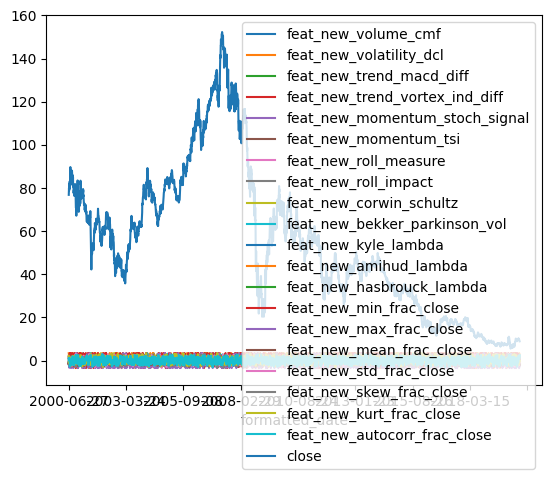

In [121]:
dataset.plot()

In [130]:
def createXY(inputs, outputs, training=False):

    def flatten_features_window(x):
        mean = x.mean(axis=1)
        std = x.std(axis=1)
        low = x.min(axis=1)
        high = x.max(axis=1)
        open_f = x[:, 0]
        close_f = x[:, -1]
        return close_f

    X, Y, P = [], [], []

    # FIXED IID ASSUMPTION (up to some point)
    if training:
        SKIP = INPUT_WINDOW + HORIZON
    else:
        SKIP = 1

    for i in range(INPUT_WINDOW, len(inputs)-HORIZON, SKIP):

        window = inputs[i-INPUT_WINDOW:i].values
        future = (outputs[i+HORIZON] - outputs[i]) / outputs[i]
        future_binary = 1.0 if future > 0 else 0.0

        X.append(window)
        Y.append(future_binary)
        P.append(future)

    X, Y, P = np.array(X), np.array(Y), np.array(P)
    X = flatten_features_window(X)
    return X, Y, P

In [123]:
dataset.head()

,feat_new_volume_cmf,feat_new_volatility_dcl,feat_new_trend_macd_diff,feat_new_trend_vortex_ind_diff,feat_new_momentum_stoch_signal,feat_new_momentum_tsi,feat_new_roll_measure,feat_new_roll_impact,feat_new_corwin_schultz,feat_new_bekker_parkinson_vol,...,feat_new_amihud_lambda,feat_new_hasbrouck_lambda,feat_new_min_frac_close,feat_new_max_frac_close,feat_new_mean_frac_close,feat_new_std_frac_close,feat_new_skew_frac_close,feat_new_kurt_frac_close,feat_new_autocorr_frac_close,close
formatted_date,,,,,,,,,,,,,,,,,,,,,
2000-06-27,-1.401626,3.396274,-1.248908,-1.247833,-1.248855,-1.754731,1.193484,1.234272,-0.470335,-0.394955,...,-1.103564,-1.075792,-1.248139,-1.523624,-1.590138,-0.214252,1.718595,2.150011,0.784938,76.812981
2000-06-28,-1.437247,2.860950,-0.836937,-1.069914,-0.711806,-1.434371,2.010396,2.288285,-0.749028,1.005972,...,-0.606556,-0.462599,-1.084082,-1.292837,-1.198371,0.601045,0.862431,0.703486,0.852375,78.602097
2000-06-29,-1.150298,2.105330,-0.385781,-0.707880,-0.187770,-1.117449,2.225328,0.790394,-0.361955,-0.564017,...,-0.231878,-0.011909,-0.939275,-1.112697,-0.966713,0.941179,0.598205,0.090255,1.034314,80.033394
2000-06-30,-1.278117,1.693857,-0.177446,-0.753498,0.102585,-0.983476,1.496473,1.106413,-0.808871,-0.290948,...,0.170210,0.425284,-0.812950,-0.963624,-0.920284,0.889249,0.902547,0.037216,0.743362,78.781013
2000-07-03,-0.598398,1.418462,0.233414,-0.574148,0.432765,-0.742614,0.820091,-0.905969,-0.694626,1.083034,...,0.093795,0.380632,-0.698407,-0.834523,-0.776565,0.915984,0.765161,-0.177159,-0.008369,80.749046


In [131]:
# training for longer time!
# dataset_train = dataset[:'2018']
# dataset_test = dataset['2019':]

# dataset_train = dataset['2000':'2001']
# dataset_test = dataset['2002':'2003']

dataset_train = dataset['2000':'2005']
dataset_test = dataset['2006':'2010']

In [132]:
dataset_train[FEATURE_COLUMNS].head()

,feat_new_volume_cmf,feat_new_volatility_dcl,feat_new_trend_macd_diff,feat_new_trend_vortex_ind_diff,feat_new_momentum_stoch_signal,feat_new_momentum_tsi,feat_new_roll_measure,feat_new_roll_impact,feat_new_corwin_schultz,feat_new_bekker_parkinson_vol,feat_new_kyle_lambda,feat_new_amihud_lambda,feat_new_hasbrouck_lambda,feat_new_min_frac_close,feat_new_max_frac_close,feat_new_mean_frac_close,feat_new_std_frac_close,feat_new_skew_frac_close,feat_new_kurt_frac_close,feat_new_autocorr_frac_close
formatted_date,,,,,,,,,,,,,,,,,,,,
2000-06-27,-1.401626,3.396274,-1.248908,-1.247833,-1.248855,-1.754731,1.193484,1.234272,-0.470335,-0.394955,-1.078223,-1.103564,-1.075792,-1.248139,-1.523624,-1.590138,-0.214252,1.718595,2.150011,0.784938
2000-06-28,-1.437247,2.860950,-0.836937,-1.069914,-0.711806,-1.434371,2.010396,2.288285,-0.749028,1.005972,-0.565522,-0.606556,-0.462599,-1.084082,-1.292837,-1.198371,0.601045,0.862431,0.703486,0.852375
2000-06-29,-1.150298,2.105330,-0.385781,-0.707880,-0.187770,-1.117449,2.225328,0.790394,-0.361955,-0.564017,-0.171585,-0.231878,-0.011909,-0.939275,-1.112697,-0.966713,0.941179,0.598205,0.090255,1.034314
2000-06-30,-1.278117,1.693857,-0.177446,-0.753498,0.102585,-0.983476,1.496473,1.106413,-0.808871,-0.290948,0.250165,0.170210,0.425284,-0.812950,-0.963624,-0.920284,0.889249,0.902547,0.037216,0.743362
2000-07-03,-0.598398,1.418462,0.233414,-0.574148,0.432765,-0.742614,0.820091,-0.905969,-0.694626,1.083034,0.144969,0.093795,0.380632,-0.698407,-0.834523,-0.776565,0.915984,0.765161,-0.177159,-0.008369


In [134]:
# fixed train / test set
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

[[-1.40162566  3.39627368 -1.24890785 ...  1.71859489  2.15001096
   0.78493756]
 [-0.59839798  1.4184618   0.23341406 ...  0.76516129 -0.17715937
  -0.00836944]
 [-1.57948906  0.78616269  1.43633655 ... -2.18409569 -1.2477119
   0.63287601]
 ...
 [ 1.36357195  1.00501128 -1.95678092 ...  0.78609505 -0.28327687
   0.56634446]
 [ 0.10121443  0.72389861 -1.53683253 ...  1.1588302   1.42256643
   1.31216085]
 [-1.51098343  1.78051232 -0.10088136 ... -1.80064771 -1.58565327
   0.97117445]]
[[-1.17607971  0.52414619  1.50347458 ...  3.16928429  2.9395699
  -1.4140917 ]
 [-0.50479669  0.41852518  2.80451469 ...  2.00571901  1.13945504
   2.36086786]
 [ 1.23484373  0.15578994  2.34080154 ...  0.90038933  0.05644528
   1.65754681]
 ...
 [ 0.34467557 -0.98107174 -0.10675129 ...  0.65313201  1.32114399
  -0.65090005]
 [-0.17483922 -0.92033144  0.50278434 ...  0.78011559  1.17657608
  -0.46960803]
 [-1.23300878 -0.71824301  1.31363886 ...  1.97221993  2.62053553
  -0.57530185]]


In [135]:
dataset['close']

formatted_date
2000-06-27    76.812981
2000-06-28    78.602097
2000-06-29    80.033394
2000-06-30    78.781013
2000-07-03    80.749046
                ...    
2020-07-27     9.550000
2020-07-28     9.450000
2020-07-29     9.220000
2020-07-30     9.000000
2020-07-31     8.920000
Name: close, Length: 3933, dtype: float64

In [136]:
P_train

array([ 0.02498106,  0.02352937,  0.04441268, -0.00274724, -0.05263155,
        0.0099715 ,  0.02500004,  0.03004289, -0.01694915, -0.0044248 ,
        0.00762196, -0.03030305,  0.02095806,  0.00755288, -0.04497755,
        0.00841752,  0.05218853, -0.00161284,  0.04307698, -0.03328291,
        0.0199006 ,  0.04498267, -0.00624031, -0.04347831, -0.02866236,
       -0.01578197,  0.01463104, -0.00607909,  0.01141409, -0.00430239,
        0.02651041,  0.00751888, -0.01098897, -0.01307193,  0.01367992,
        0.02073254,  0.01137119,  0.01230775, -0.01587295,  0.01294966,
        0.01270753,  0.01872661,  0.00483166, -0.01234563,  0.02536229,
        0.01107005,  0.01396651, -0.04856687, -0.13489736,  0.00886701,
        0.04251205, -0.01672244,  0.03385132, -0.0394265 ,  0.04089347,
       -0.011041  ,  0.04130298,  0.0081164 , -0.02003084, -0.00957918,
       -0.02366859, -0.01379808,  0.03484057, -0.02114966,  0.        ,
        0.00130888, -0.03632322,  0.00241348, -0.01535838, -0.02

In [137]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((215, 20), (215,), (808, 20), (808,))

# Modeling

In [138]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    pred_pr = clf.predict_proba(X_test)[:, 1]

    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

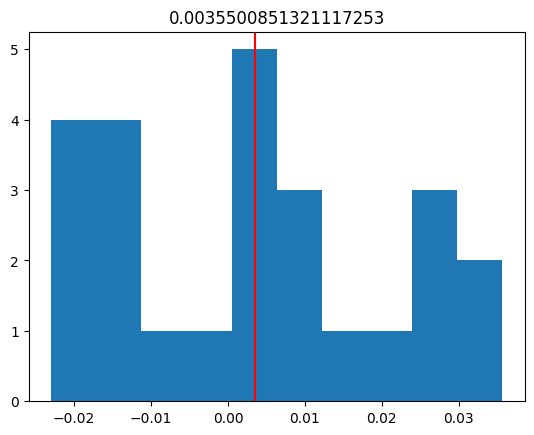

In [139]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

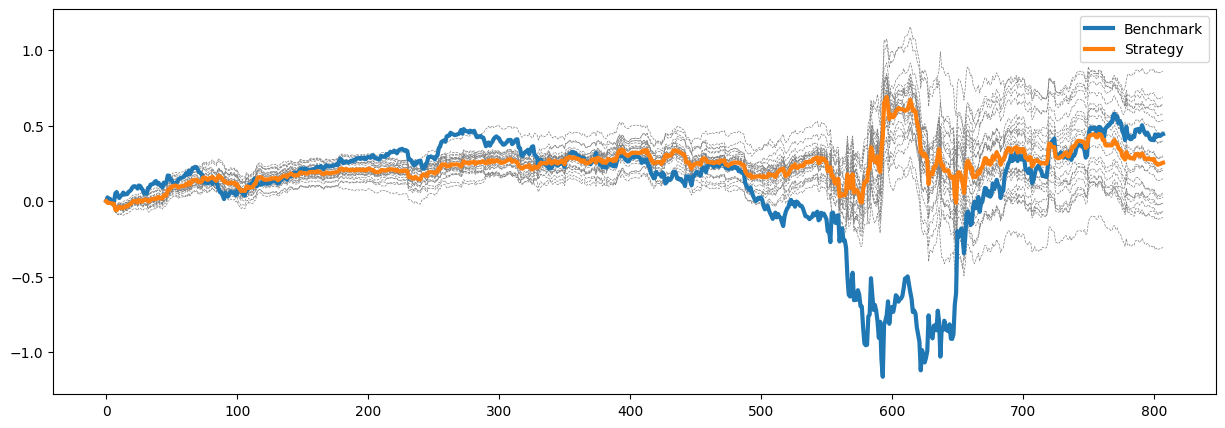

In [140]:
bagging_strategies, bagging_returns = [], []
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)

plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [141]:
benchmark_returns = P_test
strategy_returns = np.array(bagging_returns).mean(axis=0)

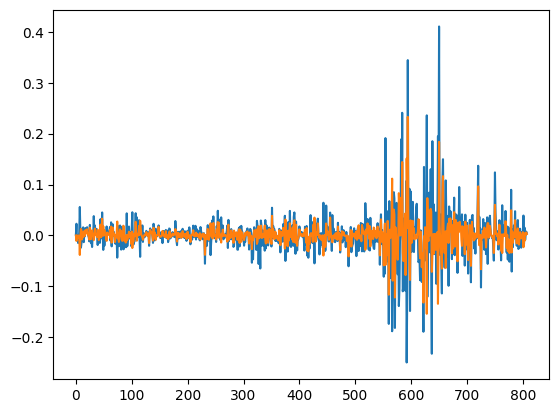

In [142]:
plt.figure()
plt.plot(benchmark_returns)
plt.plot(strategy_returns)
plt.show()

In [143]:
np.mean(benchmark_returns), np.mean(strategy_returns)

(0.0005493313051777071, 0.0003150781752049629)

# Evaluation

In [163]:
"""
Implements statistics related to:
- flattening and flips
- average period of position holding
- concentration of bets
- drawdowns
- various Sharpe ratios
- minimum track record length
"""

import pandas as pd
import scipy.stats as ss
import numpy as np


def timing_of_flattening_and_flips(target_positions: pd.Series) -> pd.DatetimeIndex:
    """
    Snippet 14.1, page 197, Derives the timestamps of flattening or flipping
    trades from a pandas series of target positions. Can be used for position
    changes analysis, such as frequency and balance of position changes.

    Flattenings - times when open position is bing closed (final target position is 0).
    Flips - times when positive position is reversed to negative and vice versa.

    :param target_positions: (pd.Series) target position series with timestamps as indices
    :return: (pd.DatetimeIndex) timestamps of trades flattening, flipping and last bet
    """
    empty_positions = target_positions[(target_positions == 0)].index  # Empty positions index
    previous_positions = target_positions.shift(1)  # Timestamps pointing at previous positions
    # Index of positions where previous one wasn't empty
    previous_positions = previous_positions[(previous_positions != 0)].index
    # FLATTENING - if previous position was open, but current is empty
    flattening = empty_positions.intersection(previous_positions)
    # Multiplies current position with value of next one
    multiplied_posions = target_positions.iloc[1:] * target_positions.iloc[:-1].values
    # FLIPS - if current position has another direction compared to the next
    flips = multiplied_posions[(multiplied_posions < 0)].index
    flips_and_flattenings = flattening.union(flips).sort_values()
    if target_positions.index[-1] not in flips_and_flattenings:  # Appending with last bet
        flips_and_flattenings = flips_and_flattenings.append(target_positions.index[-1:])
    return flips_and_flattenings


def average_holding_period(target_positions: pd.Series) -> float:
    """
    Snippet 14.2, page 197, Estimates the average holding period (in days) of a strategy,
    given a pandas series of target positions using average entry time pairing algorithm.

    Idea of an algorithm:
    - entry_time = (previous_time * weight_of_previous_position +
                    time_since_beginning_of_trade * increase_in_position ) /
                    weight_of_current_position
    - holding_period ['holding_time' = time a position was held,
                      'weight' = weight of position closed]
    - res = weighted average time a trade was held

    :param target_positions: (pd.Series) target position series with timestamps as indices
    :return: (float) estimated average holding period, NaN if zero or unpredicted
    """
    holding_period = pd.DataFrame(columns=['holding_time', 'weight'])
    entry_time = 0
    position_difference = target_positions.diff()

    # Time elapsed from the starting time for each position
    time_difference = (target_positions.index - target_positions.index[0]) / \
                      np.timedelta64(1, 'D')
    for i in range(1, target_positions.shape[0]):

        # Increased or unchanged position
        if float(position_difference.iloc[i] * target_positions.iloc[i - 1]) >= 0:
            if float(target_positions.iloc[i]) != 0:  # And not an empty position
                entry_time = (entry_time * target_positions.iloc[i - 1] +
                              time_difference[i] * position_difference.iloc[i]) / \
                             target_positions.iloc[i]

        # Decreased
        if float(position_difference.iloc[i] * target_positions.iloc[i - 1]) < 0:
            hold_time = time_difference[i] - entry_time

            # Flip of a position
            if float(target_positions.iloc[i] * target_positions.iloc[i - 1]) < 0:
                weight = abs(target_positions.iloc[i - 1])
                holding_period.loc[target_positions.index[i],
                                   ['holding_time', 'weight']] = (hold_time, weight)
                entry_time = time_difference[i]  # Reset entry time

            # Only a part of position is closed
            else:
                weight = abs(position_difference.iloc[i])
                holding_period.loc[target_positions.index[i],
                                   ['holding_time', 'weight']] = (hold_time, weight)

    if float(holding_period['weight'].sum()) > 0:  # If there were closed trades at all
        avg_holding_period = float((holding_period['holding_time'] * \
                                    holding_period['weight']).sum() / \
                                   holding_period['weight'].sum())
    else:
        avg_holding_period = float('nan')

    return avg_holding_period


def bets_concentration(returns: pd.Series) -> float:
    """
    Snippet 14.3, page 201, Derives the concentration of returns from given
    pd.Series of returns.

    Algorithm is based on Herfindahl-Hirschman Index where return weights
    are taken as an input.

    :param returns: (pd.Series) returns from bets
    :return: (float) concentration of returns (nan if less than 3 returns)
    """
    if returns.shape[0] <= 2:
        return float('nan')  # If less than 3 bets
    weights = returns / returns.sum()  # Weights of each bet
    hhi = (weights ** 2).sum()  # Herfindahl-Hirschman Index for weights
    hhi = float((hhi - returns.shape[0] ** (-1)) / (1 - returns.shape[0] ** (-1)))
    return hhi


def all_bets_concentration(returns: pd.Series, frequency: str = 'M') -> tuple:
    """
    Snippet 14.3, page 201, Given a pd.Series of returns, derives concentration of
    positive returns, negative returns and concentration of bets grouped by
    time intervals (daily, monthly etc.). If after time grouping less than
    3 observations, returns nan.

    Properties or results:
    - low positive_concentration -> no right fat-tail of returns (desirable)
    - low negative_concentration -> no left fat-tail of returns (desirable)
    - low time_concentration -> bets are not concentrated in time, or
                                are evenly concentrated (desirable)
    - positive_concentration == 0 ⇔ returns are uniform
    - positive_concentration == 1 ⇔ only one non-zero return exists

    :param returns: (pd.Series) returns from bets
    :param frequency: (str) desired time grouping frequency from pd.Grouper
    :return: (tuple of floats) concentration of positive, negative
                            and time grouped concentrations
    """
    # Concentration of positive returns per bet
    positive_concentration = bets_concentration(returns[returns >= 0])
    # Concentration of negative returns per bet
    negative_concentration = bets_concentration(returns[returns < 0])
    # Concentration of bets/time period (month by default)
    time_concentration = \
        bets_concentration(returns.groupby(pd.Grouper(freq=frequency)).count())
    return (positive_concentration, negative_concentration, time_concentration)


def drawdown_and_time_under_water(returns: pd.Series, dollars: bool = False) -> tuple:
    """
    Snippet 14.4, page 201, Calculates drawdowns and time under water for pd.Series
    of returns or dollar performance.
    Intuitively, a drawdown is the maximum loss suffered by an investment between
    two consecutive high-watermarks. The time under water is the time
    elapsed between an high watermark and the moment the PnL (profit and loss)
    exceeds the previous maximum PnL.

    Return details:
    - Drawdown series index is time of a high watermark and value of a drawdown after.
    - Time under water index is time of a high watermark and how much time passed till
    next high watermark in years.

    :param returns: (pd.Series) returns from bets
    :param dollars: (bool) flag if given dollar performance and not returns
    :return: (tuple of pd.Series) series of drawdowns and time under water
                                if dollars, then in dollars, else as a %
    """
    frame = returns.to_frame('pnl')
    frame['hwm'] = returns.expanding().max()  # Adding high watermarks as column
    # Grouped as min returns by high watermarks
    high_watermarks = frame.groupby('hwm').min().reset_index()
    high_watermarks.columns = ['hwm', 'min']
    # Time high watermark occured
    high_watermarks.index = frame['hwm'].drop_duplicates(keep='first').index
    # Picking ones that had a drawdown after high watermark
    high_watermarks = high_watermarks[high_watermarks['hwm'] > high_watermarks['min']]
    if dollars:
        drawdown = high_watermarks['hwm'] - high_watermarks['min']
    else:
        drawdown = 1 - high_watermarks['min'] / high_watermarks['hwm']
    time_under_water = ((high_watermarks.index[1:] -
                         high_watermarks.index[:-1]) / np.timedelta64(1, 'Y')).values
    time_under_water = pd.Series(time_under_water, index=high_watermarks.index[:-1])
    return drawdown, time_under_water


def sharpe_ratio(returns: pd.Series, cumulative: bool = False,
                 entries_per_year: int = 252, risk_free_rate: float = 0) -> float:
    """
    Calculates Annualized Sharpe Ratio for pd.Series of normal (not log) returns.

    :param returns: (pd.Series) returns
    :param cumulative: (bool) flag if returns are cumulative (no by default)
    :param entries_per_year: (int) times returns are recorded per year (days by default)
    :param risk_free_rate: (float) risk-free rate (0 by default)
    :return: (float) Annualized Sharpe Ratio
    """
    if cumulative:
        returns = returns / returns.shift(1) - 1  # Inverting cumulative returns
        returns = returns[1:]  # Excluding empty value
    sharpe_r = (returns.mean() - risk_free_rate) / returns.std() * \
               (entries_per_year) ** (1 / 2)

    return sharpe_r

def probabilistic_sharpe_ratio(observed_sr: float, benchmark_sr: float,
                               number_of_returns: int, skewness_of_returns: float = 0,
                               kurtosis_of_returns: float = 3) -> float:
    """
    Calculates the probabilistic Sharpe ratio (PSR) that provides an adjusted estimate of SR,
    by removing the inflationary effect caused by short series with skewed and/or
    fat-tailed returns.

    Given a user-defined benchmark Sharpe ratio and an observed Sharpe ratio,
    PSR estimates the probability that SR ̂is greater than a hypothetical SR.
    - It should exceed 0.95, for the standard significance level of 5%.
    - It can be computed on absolute or relative returns.

    :param observed_sr: (float) Sharpe Ratio that is observed
    :param benchmark_sr: (float) Sharpe Ratio to which observed_SR is tested against
    :param  number_of_returns: (int) times returns are recorded for observed_SR
    :param skewness_of_returns: (float) skewness of returns (as Gaussian by default)
    :param kurtosis_of_returns: (float) kurtosis of returns (as Gaussian by default)
    :return: (float) Probabalistic Sharpe Ratio
    """

    probab_sr = ss.norm.cdf(((observed_sr - benchmark_sr) * (number_of_returns - 1) ** (1 / 2)) / \
                            (1 - skewness_of_returns * observed_sr +
                             (kurtosis_of_returns - 1) / 4 * observed_sr ** 2) ** (1 / 2))

    return probab_sr


def deflated_sharpe_ratio(observed_sr: float, sr_estimates: list,
                          number_of_returns: int, skewness_of_returns: float = 0,
                          kurtosis_of_returns: float = 3) -> float:
    """
    Calculates the deflated Sharpe ratio (DSR) - a PSR where the rejection threshold is
    adjusted to reflect the multiplicity of trials. DSR is estimated as PSR[SR∗], where
    the benchmark Sharpe ratio, SR∗, is no longer user-defined, but calculated from
    SR estimate trails.

    DSR corrects SR for inflationary effects caused by non-Normal returns, track record
    length, and multiple testing/selection bias.
    - It should exceed 0.95, for the standard significance level of 5%.
    - It can be computed on absolute or relative returns.

    :param observed_sr: (list) Sharpe Ratio that is being tested
    :param sr_estimates: (float) Sharpe Ratios estimates trials
    :param  number_of_returns: (int) times returns are recorded for observed_SR
    :param skewness_of_returns: (float) skewness of returns (as Gaussian by default)
    :param kurtosis_of_returns: (float) kurtosis of returns (as Gaussian by default)
    :return: (float) Deflated Sharpe Ratio
    """
    # Calculating benchmark_SR from a list of estimates
    benchmark_sr = np.array(sr_estimates).std() * \
                   ((1 - np.euler_gamma) * ss.norm.ppf(1 - 1 / len(sr_estimates)) +
                    np.euler_gamma * ss.norm.ppf(1 - 1 / len(sr_estimates) * np.e ** (-1)))

    deflated_sr = probabalistic_sharpe_ratio(observed_sr, benchmark_sr, number_of_returns,
                                             skewness_of_returns, kurtosis_of_returns)

    return deflated_sr


def minimum_track_record_length(observed_sr: float, benchmark_sr: float,
                                skewness_of_returns: float = 0,
                                kurtosis_of_returns: float = 3,
                                alpha: float = 0.05) -> float:
    """
    Calculates the Minimum Track Record Length - "How long should a track record be
    in order to have statistical confidence that its Sharpe ratio is above a given
    threshold?”

    If a track record is shorter than MinTRL, we do not  have  enough  confidence
    that  the  observed Sharpe ratio ̂is  above  the  designated Sharpe ratio
    threshold.
    MinTRLis expressed in terms of number of observations, not annual or calendar terms.

    :param observed_sr: (float) Sharpe Ratio that is being tested
    :param benchmark_sr: (float) Sharpe Ratio to which observed_SR is tested against
    :param  number_of_returns: (int) times returns are recorded for observed_SR
    :param skewness_of_returns: (float) skewness of returns (as Gaussian by default)
    :param kurtosis_of_returns: (float) kurtosis of returns (as Gaussian by default)
    :param alpha: (float) desired significance level
    :return: (float) Probabalistic Sharpe Ratio
    """

    track_rec_length = 1 + (1 - skewness_of_returns * observed_sr +
                            (kurtosis_of_returns - 1) / 4 * observed_sr ** 2) * \
                       (ss.norm.ppf(1 - alpha) / (observed_sr - benchmark_sr)) ** (2)

    return track_rec_length
import pandas as pd
import numpy as np

def information_ratio(returns: pd.Series, benchmark: float = 0, entries_per_year: int = 252) -> float:
    """
    Calculates annualized information ratio for pd.Series of normal or log returns.

    Benchmark should be provided as a return for the same time period as that between
    input returns. For example, for the daily observations it should be the
    benchmark of daily returns.

    It is the annualized ratio between the average excess return and the tracking error.
    The excess return is measured as the portfolio’s return in excess of the benchmark’s
    return. The tracking error is estimated as the standard deviation of the excess returns.

    :param returns: (pd.Series) Returns - normal or log
    :param benchmark: (float) Benchmark for performance comparison (0 by default)
    :param entries_per_year: (int) Times returns are recorded per year (252 by default)
    :return: (float) Annualized information ratio
    """

    # Calculate excess returns
    excess_returns = returns - benchmark

    # Calculate average excess return
    avg_excess_return = np.mean(excess_returns)

    # Calculate tracking error (standard deviation of excess returns)
    tracking_error = np.std(excess_returns)

    # Calculate annualized information ratio
    information_ratio = (avg_excess_return * entries_per_year) / tracking_error

    return information_ratio



In [149]:
# from mlfinlab.backtest_statistics import sharpe_ratio
# from mlfinlab.backtest_statistics import probabilistic_sharpe_ratio
# from mlfinlab.backtest_statistics import deflated_sharpe_ratio
# from mlfinlab.backtest_statistics import information_ratio
# from mlfinlab.backtest_statistics import minimum_track_record_length
# from mlfinlab.backtest_statistics import drawdown_and_time_under_water

In [150]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(252))

In [151]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
benchmark_sharpe, benchmark_sharpe_smart

(0.19559685907201166, 0.18487016324012592)

In [152]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe_smart = smart_sharpe(strategy_returns)
strategy_sharpe, strategy_sharpe_smart

(0.20052071195589066, 0.18574431967177288)

In [156]:
psr = probabilistic_sharpe_ratio(strategy_sharpe, benchmark_sharpe, len(benchmark_returns))
psr

0.5550735570061973

In [162]:
all_strategy_sharpes = []
for r in bagging_returns:
    sr_i = sharpe_ratio(r, entries_per_year=252)
    all_strategy_sharpes.append(sr_i)

dsr = deflated_sharpe_ratio(strategy_sharpe, all_strategy_sharpes, len(benchmark_returns))
dsr

2.276901481029086e-09

In [164]:
ir = information_ratio(strategy_returns, benchmark=np.mean(benchmark_returns), entries_per_year=252)
ir

-2.3666094218297613

In [165]:
mtrl = minimum_track_record_length(strategy_sharpe, benchmark_sharpe)
mtrl

113839.4425540959

# Checking Feature Importance

In [167]:
!pip install shap

In [168]:
import shap
from sklearn.ensemble import RandomForestClassifier

In [169]:
# fixed train / test set
X_train, Y_train, P_train = createXY(dataset_train[FEATURE_COLUMNS], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[FEATURE_COLUMNS], dataset_test['close'])

[[-1.40162566  3.39627368 -1.24890785 ...  1.71859489  2.15001096
   0.78493756]
 [-0.59839798  1.4184618   0.23341406 ...  0.76516129 -0.17715937
  -0.00836944]
 [-1.57948906  0.78616269  1.43633655 ... -2.18409569 -1.2477119
   0.63287601]
 ...
 [ 1.36357195  1.00501128 -1.95678092 ...  0.78609505 -0.28327687
   0.56634446]
 [ 0.10121443  0.72389861 -1.53683253 ...  1.1588302   1.42256643
   1.31216085]
 [-1.51098343  1.78051232 -0.10088136 ... -1.80064771 -1.58565327
   0.97117445]]
[[-1.17607971  0.52414619  1.50347458 ...  3.16928429  2.9395699
  -1.4140917 ]
 [-0.50479669  0.41852518  2.80451469 ...  2.00571901  1.13945504
   2.36086786]
 [ 1.23484373  0.15578994  2.34080154 ...  0.90038933  0.05644528
   1.65754681]
 ...
 [ 0.34467557 -0.98107174 -0.10675129 ...  0.65313201  1.32114399
  -0.65090005]
 [-0.17483922 -0.92033144  0.50278434 ...  0.78011559  1.17657608
  -0.46960803]
 [-1.23300878 -0.71824301  1.31363886 ...  1.97221993  2.62053553
  -0.57530185]]


In [170]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((215, 20), (215,), (808, 20), (808,))

In [171]:
X_train_df = pd.DataFrame(X_train, columns = FEATURE_COLUMNS)
X_test_df = pd.DataFrame(X_test, columns = FEATURE_COLUMNS)

In [172]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', criterion='entropy')
clf.fit(X_train_df, Y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_df)

fi0 = np.abs(shap_values[0]).mean(axis=0)
fi1 = np.abs(shap_values[1]).mean(axis=0)
fi = fi0 + fi1
imp = pd.DataFrame({
    'feature': X_train_df.columns.tolist(),
    'mean': fi
})
imp = imp.set_index('feature')

<Axes: ylabel='feature'>

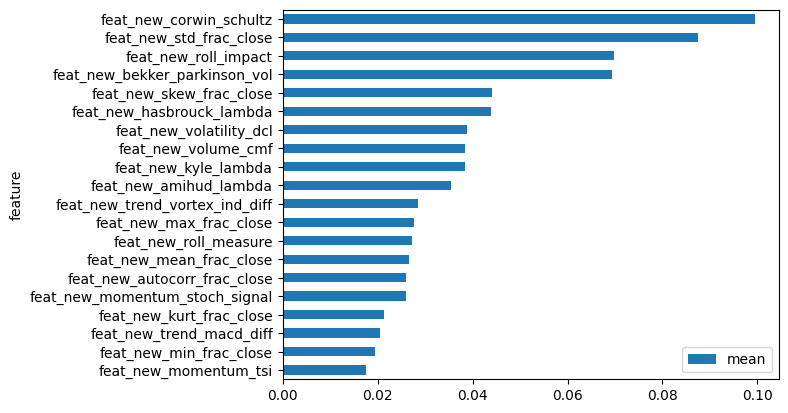

In [173]:
imp.sort_values('mean').plot.barh()

In [174]:
IMPORTANT_FEATURES = imp.sort_values('mean')[::-1][3:-3].index.values.tolist()
# IMPORTANT_FEATURES = imp[imp['mean'] > 0.0].index.values.tolist()
# IMPORTANT_FEATURES = FEATURE_COLUMNS

In [175]:
IMPORTANT_FEATURES

['feat_new_bekker_parkinson_vol',
 'feat_new_skew_frac_close',
 'feat_new_hasbrouck_lambda',
 'feat_new_volatility_dcl',
 'feat_new_volume_cmf',
 'feat_new_kyle_lambda',
 'feat_new_amihud_lambda',
 'feat_new_trend_vortex_ind_diff',
 'feat_new_max_frac_close',
 'feat_new_roll_measure',
 'feat_new_mean_frac_close',
 'feat_new_autocorr_frac_close',
 'feat_new_momentum_stoch_signal',
 'feat_new_kurt_frac_close']

# Retraining on the best features

In [176]:
X_train, Y_train, P_train = createXY(dataset_train[IMPORTANT_FEATURES], dataset_train['close'], training=True)
X_test, Y_test, P_test = createXY(dataset_test[IMPORTANT_FEATURES], dataset_test['close'])

[[-0.39495455  1.71859489 -1.07579181 ...  0.78493756 -1.24885453
   2.15001096]
 [ 1.08303362  0.76516129  0.38063168 ... -0.00836944  0.43276455
  -0.17715937]
 [ 1.34265166 -2.18409569 -0.1384763  ...  0.63287601  1.34289373
  -1.2477119 ]
 ...
 [ 0.38060759  0.78609505 -0.47620568 ...  0.56634446 -1.47273253
  -0.28327687]
 [-0.15869821  1.1588302  -1.08793632 ...  1.31216085 -1.80896161
   1.42256643]
 [ 0.23171754 -1.80064771 -0.6882754  ...  0.97117445 -0.01747329
  -1.58565327]]
[[ 2.62676233  3.16928429  1.81456647 ... -1.4140917   0.26116127
   2.9395699 ]
 [ 2.26567167  2.00571901  2.29147521 ...  2.36086786  2.38288056
   1.13945504]
 [ 0.47076741  0.90038933  1.78584212 ...  1.65754681  2.20522352
   0.05644528]
 ...
 [ 0.74637537  0.65313201 -1.78831031 ... -0.65090005 -0.24490875
   1.32114399]
 [-0.81218237  0.78011559 -1.34114821 ... -0.46960803  0.31897548
   1.17657608]
 [-1.35345508  1.97221993 -1.16438268 ... -0.57530185  0.55385135
   2.62053553]]


In [177]:
mmcs, pred_prs = [], []
for n in range(N_SAMPLES):

    clf = create_model()

    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    pred_pr = clf.predict_proba(X_test)[:, 1]

    mmcs.append(matthews_corrcoef(Y_test, pred))
    pred_prs.append(pred_pr)

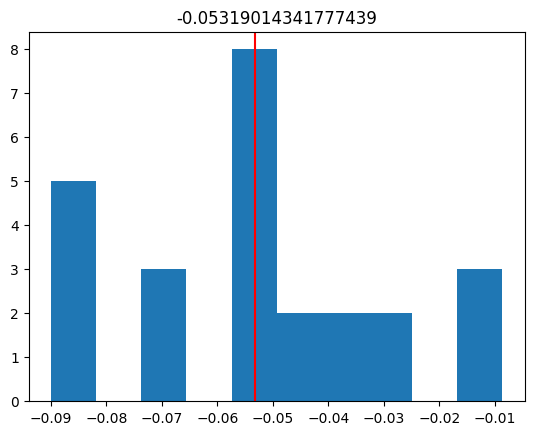

In [178]:
plt.figure()
plt.title(str(np.mean(mmcs)))
plt.hist(mmcs)
plt.axvline(np.mean(mmcs), color = 'red')
plt.show()

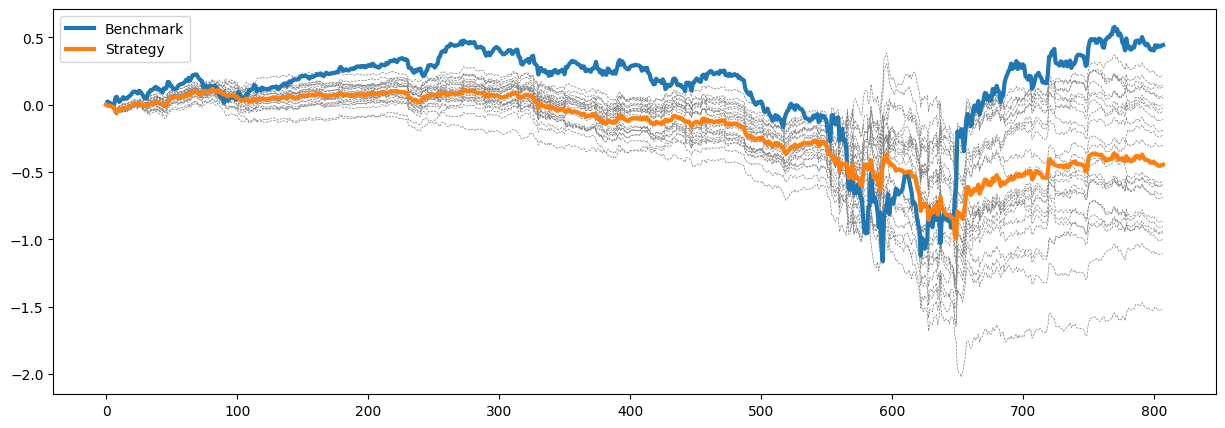

In [179]:
bagging_strategies, bagging_returns = [], []
plt.figure(figsize = (15, 5))

for pred_pr in pred_prs:
    signal = [-(1-p) if p <= 0.5 else p for p in pred_pr]
    bagging_strategies.append((signal * P_test).cumsum())
    bagging_returns.append(signal * P_test)
    plt.plot((signal * P_test).cumsum(), color = 'grey', ls = '--', lw=0.5)

plt.plot(P_test.cumsum(), lw = 3, label = 'Benchmark')
plt.plot(np.array(bagging_strategies).mean(axis=0), lw = 3, label = 'Strategy')

plt.legend()
plt.show()

In [180]:
strategy_returns_features = np.array(bagging_returns).mean(axis=0)

In [181]:
benchmark_sharpe = sharpe_ratio(benchmark_returns, entries_per_year=252)
benchmark_sharpe_smart = smart_sharpe(benchmark_returns)
benchmark_sharpe, benchmark_sharpe_smart

(0.19559685907201166, 0.18487016324012592)

In [182]:
strategy_sharpe = sharpe_ratio(strategy_returns, entries_per_year=252)
strategy_sharpe_smart = smart_sharpe(strategy_returns)
strategy_sharpe, strategy_sharpe_smart

(0.20052071195589066, 0.18574431967177288)

In [183]:
strategy_sharpe_features = sharpe_ratio(strategy_returns_features, entries_per_year=252)
strategy_sharpe_features_smart = smart_sharpe(strategy_returns_features)
strategy_sharpe_features, strategy_sharpe_features_smart

(-0.4118909206784998, -0.4052669071782179)

In [184]:
psr = probabilistic_sharpe_ratio(strategy_sharpe_features, strategy_sharpe, len(benchmark_returns))
psr

6.20996665895206e-63